
# Import Libraries


In [12]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm
from io import StringIO
import sys


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)


In [13]:

# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])



In [39]:

# Dataset and Creating Train/Test Split

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)



In [ ]:
# Dataloader Arguments & Test/Train Dataloaders

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)



CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like



[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)
torch.Size([512, 1, 28, 28])
torch.Size([512])


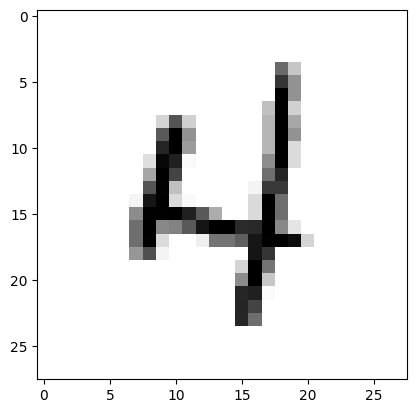

In [41]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
raw_train_data = train.data  

# Convert to float and scale to [0, 1]
float_data = raw_train_data.float() / 255.0  

print('[Train]')
print(' - Numpy Shape:', raw_train_data.numpy().shape)
print(' - Tensor Shape:', raw_train_data.size())
print(' - min:', torch.min(float_data))
print(' - max:', torch.max(float_data))
print(' - mean:', torch.mean(float_data))
print(' - std:', torch.std(float_data))
print(' - var:', torch.var(float_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

torch.Size([128, 1, 28, 28])
torch.Size([128])


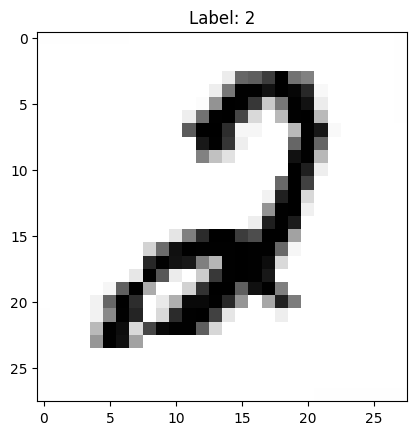

In [26]:
# Inspect a batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)  # Should be (batch_size, channels, height, width)
print(labels.shape)  # Should be (batch_size,)

# Visualize the first image in the batch
plt.imshow(images[0].squeeze(), cmap='gray_r')  # squeeze removes channel dim if 1
plt.title(f'Label: {labels[0].item()}')
plt.show()

In [11]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

NameError: name 'images' is not defined




## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on



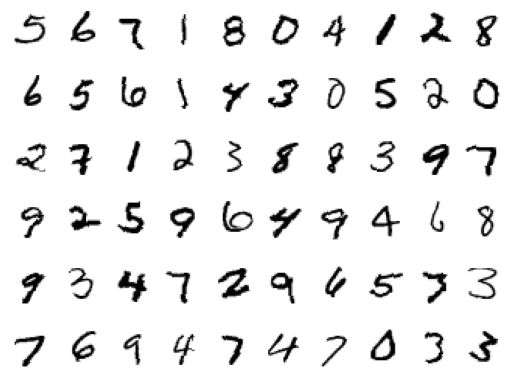

In [27]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [28]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with the model we first saw

In [227]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 3, padding=1) # 28>28 | 3
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(12, 12, 3, padding=1) # 28 > 28 |  5
        self.bn2 = nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12, 12, 3, padding=1) # 28 > 28 |  7
        self.bn3 = nn.BatchNorm2d(12)
        self.pool1 = nn.MaxPool2d(2, 2) # 28 > 14 | 8
        self.conv4 = nn.Conv2d(12, 8, 3, padding=1) # 14> 14 | 10
        self.bn4 = nn.BatchNorm2d(8)
        self.conv5 = nn.Conv2d(8, 8, 3, padding=1) #14 > 14 | 14
        self.bn5 = nn.BatchNorm2d(8)
        self.pool2 = nn.MaxPool2d(2, 2) # 14 > 7 | 18
        self.conv6 = nn.Conv2d(8, 4, 3) # 7 > 5 |26
        self.bn6 = nn.BatchNorm2d(4) 
        self.conv7 = nn.Conv2d(4, 16, 3) # 5 > 3 | 32 | 3*3*1024 | 3x3x1024x10 |
        self.conv8 = nn.Conv2d(16, 10, 3) # 3 > 1 | 34 | > 1x1x10
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3) # 7>> 9... nn.AdaptiveAvgPool((1, 1))
        ) # output_size = 1
        self.fc0 = nn.Linear(16, 100)
        self.fc1 = nn.Linear(100, 10) #RF 28x28

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool1(self.dropout(F.relu(self.bn3(self.conv3(self.dropout(F.relu(self.bn2(self.conv2(self.dropout(F.relu(self.bn1(self.conv1(x)))))))))))))
        x = self.pool2(self.dropout(F.relu(self.bn5(self.conv5(self.dropout(F.relu(self.bn4(self.conv4(x)))))))))
        x = F.relu(self.conv7(self.dropout(F.relu(self.bn6(self.conv6(x))))))
        # x = F.relu(self.conv7(x))
        x = self.gap(x)  # Global average pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc0(x))
        x = self.fc1(x)
        
        return F.log_softmax(x, dim=-1)

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 3, padding=1) # 28>28 | 3
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(12, 12, 3, padding=1) # 28 > 28 |  5
        self.bn2 = nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12, 12, 3, padding=1) # 28 > 28 |  7
        self.bn3 = nn.BatchNorm2d(12)
        self.pool1 = nn.MaxPool2d(2, 2) # 28 > 14 | 8
        self.conv4 = nn.Conv2d(12, 4, 3, padding=1) # 14> 14 | 10
        self.bn4 = nn.BatchNorm2d(4)
        self.conv5 = nn.Conv2d(4, 4, 3, padding=1) #14 > 14 | 14
        self.bn5 = nn.BatchNorm2d(4)
        self.pool2 = nn.MaxPool2d(2, 2) # 14 > 7 | 18
        self.conv6 = nn.Conv2d(4, 8, 3) # 7 > 5 |26
        self.bn6 = nn.BatchNorm2d(8) 
        self.conv7 = nn.Conv2d(8, 16, 3) # 5 > 3 | 32 | 3*3*1024 | 3x3x1024x10 |
        self.conv8 = nn.Conv2d(16, 10, 3) # 3 > 1 | 34 | > 1x1x10
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3) # 7>> 9... nn.AdaptiveAvgPool((1, 1))
        ) # output_size = 1
        self.fc0 = nn.Linear(16, 128)
        self.fc1 = nn.Linear(128, 10) #RF 28x28

        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        x = self.pool1(self.dropout(F.relu(self.bn3(self.conv3(self.dropout(F.relu(self.bn2(self.conv2(self.dropout(F.relu(self.bn1(self.conv1(x)))))))))))))
        x = self.pool2(self.dropout(F.relu(self.bn5(self.conv5(self.dropout(F.relu(self.bn4(self.conv4(x)))))))))
        x = F.relu(self.conv7(self.dropout(F.relu(self.bn6(self.conv6(x))))))
        # x = F.relu(self.conv7(x))
        x = self.gap(x)  # Global average pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc0(x))
        x = self.fc1(x)
        
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [43]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

#Get total parameter count dynamically from summary output

# Capture the summary output
old_stdout = sys.stdout
sys.stdout = captured_output = StringIO()
summary(model, input_size=(1, 28, 28))
sys.stdout = old_stdout

summary_text = captured_output.getvalue()

# Parse the summary text to find the total parameters
total_params_line = [line for line in summary_text.splitlines() if "Total params:" in line]
if total_params_line:
    total_params_str = total_params_line[0].split(":")[1].strip().replace(",", "")
    total_params = int(total_params_str)
else:
    # Fallback to manual calculation if parsing fails
    total_params = sum(p.numel() for p in model.parameters())


# Check for Batch Normalization
has_batchnorm = any(isinstance(module, nn.BatchNorm2d) for module in model.modules())

# Check for Dropout
has_dropout = any(isinstance(module, nn.Dropout) for module in model.modules())

# Check for Fully Connected Layer or Global Average Pooling
has_fc = any(isinstance(module, nn.Linear) for module in model.modules())
has_gap = any(isinstance(module, nn.AvgPool2d) or isinstance(module, nn.AdaptiveAvgPool2d) for module in model.modules())

print("## Model Details\n")
print(f"- Total Parameter Count: {total_params}\n")
print(f"- Use of Batch Normalization: {'Yes' if has_batchnorm else 'No'}\n")
print(f"- Use of Dropout: {'Yes' if has_dropout else 'No'}\n")
print(f"- Use of a Fully Connected Layer or Global Average Pooling: {'Yes' if has_fc or has_gap else 'No'}\n")

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 28, 28]             120
       BatchNorm2d-2           [-1, 12, 28, 28]              24
           Dropout-3           [-1, 12, 28, 28]               0
            Conv2d-4           [-1, 12, 28, 28]           1,308
       BatchNorm2d-5           [-1, 12, 28, 28]              24
           Dropout-6           [-1, 12, 28, 28]               0
            Conv2d-7           [-1, 12, 28, 28]           1,308
       BatchNorm2d-8           [-1, 12, 28, 28]              24
           Dropout-9           [-1, 12, 28, 28]               0
        MaxPool2d-10           [-1, 12, 14, 14]               0
           Conv2d-11            [-1, 4, 14, 14]             436
      BatchNorm2d-12            [-1, 4, 14, 14]               8
          Dropout-13            [-1, 4, 14, 14]               0
           Conv2d-14            [-


# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions




In [44]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)





In [45]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [46]:
# Let's Train and test our model
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.8)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)






EPOCH: 0


Loss=0.3151189982891083 Batch_id=117 Accuracy=70.18: 100%|██████████| 118/118 [00:07<00:00, 16.73it/s] 



Test set: Average loss: 0.1700, Accuracy: 9452/10000 (94.52%)

EPOCH: 1


Loss=0.14713867008686066 Batch_id=117 Accuracy=95.30: 100%|██████████| 118/118 [00:06<00:00, 17.17it/s]



Test set: Average loss: 0.1191, Accuracy: 9606/10000 (96.06%)

EPOCH: 2


Loss=0.15981262922286987 Batch_id=117 Accuracy=96.54: 100%|██████████| 118/118 [00:06<00:00, 17.12it/s]



Test set: Average loss: 0.0722, Accuracy: 9787/10000 (97.87%)

EPOCH: 3


Loss=0.030135663226246834 Batch_id=117 Accuracy=97.26: 100%|██████████| 118/118 [00:06<00:00, 17.15it/s]



Test set: Average loss: 0.0902, Accuracy: 9708/10000 (97.08%)

EPOCH: 4


Loss=0.025582874193787575 Batch_id=117 Accuracy=97.44: 100%|██████████| 118/118 [00:07<00:00, 16.42it/s]



Test set: Average loss: 0.0627, Accuracy: 9797/10000 (97.97%)

EPOCH: 5


Loss=0.041373614221811295 Batch_id=117 Accuracy=97.72: 100%|██████████| 118/118 [00:08<00:00, 14.52it/s]



Test set: Average loss: 0.0893, Accuracy: 9748/10000 (97.48%)

EPOCH: 6


Loss=0.08556323498487473 Batch_id=117 Accuracy=97.88: 100%|██████████| 118/118 [00:06<00:00, 17.20it/s] 



Test set: Average loss: 0.0700, Accuracy: 9769/10000 (97.69%)

EPOCH: 7


Loss=0.02268647402524948 Batch_id=117 Accuracy=97.96: 100%|██████████| 118/118 [00:06<00:00, 17.16it/s] 



Test set: Average loss: 0.0480, Accuracy: 9845/10000 (98.45%)

EPOCH: 8


Loss=0.07742948830127716 Batch_id=117 Accuracy=97.94: 100%|██████████| 118/118 [00:06<00:00, 17.15it/s] 



Test set: Average loss: 0.0694, Accuracy: 9783/10000 (97.83%)

EPOCH: 9


Loss=0.017913833260536194 Batch_id=117 Accuracy=98.06: 100%|██████████| 118/118 [00:09<00:00, 11.81it/s]



Test set: Average loss: 0.0392, Accuracy: 9883/10000 (98.83%)

EPOCH: 10


Loss=0.10852032899856567 Batch_id=117 Accuracy=98.54: 100%|██████████| 118/118 [00:06<00:00, 17.36it/s] 



Test set: Average loss: 0.0369, Accuracy: 9884/10000 (98.84%)

EPOCH: 11


Loss=0.035949088633060455 Batch_id=117 Accuracy=98.64: 100%|██████████| 118/118 [00:06<00:00, 17.56it/s]



Test set: Average loss: 0.0383, Accuracy: 9881/10000 (98.81%)

EPOCH: 12


Loss=0.08099521696567535 Batch_id=117 Accuracy=98.57: 100%|██████████| 118/118 [00:06<00:00, 16.99it/s] 



Test set: Average loss: 0.0365, Accuracy: 9889/10000 (98.89%)

EPOCH: 13


Loss=0.05361650511622429 Batch_id=117 Accuracy=98.60: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s] 



Test set: Average loss: 0.0350, Accuracy: 9892/10000 (98.92%)

EPOCH: 14


Loss=0.052563924342393875 Batch_id=117 Accuracy=98.57: 100%|██████████| 118/118 [00:10<00:00, 11.46it/s]



Test set: Average loss: 0.0374, Accuracy: 9884/10000 (98.84%)

EPOCH: 15


Loss=0.018200799822807312 Batch_id=117 Accuracy=98.64: 100%|██████████| 118/118 [00:06<00:00, 17.01it/s]



Test set: Average loss: 0.0358, Accuracy: 9895/10000 (98.95%)

EPOCH: 16


Loss=0.030660277232527733 Batch_id=117 Accuracy=98.64: 100%|██████████| 118/118 [00:06<00:00, 17.59it/s]



Test set: Average loss: 0.0342, Accuracy: 9894/10000 (98.94%)

EPOCH: 17


Loss=0.009638939052820206 Batch_id=117 Accuracy=98.66: 100%|██████████| 118/118 [00:06<00:00, 17.41it/s]



Test set: Average loss: 0.0359, Accuracy: 9891/10000 (98.91%)

EPOCH: 18


Loss=0.04455886408686638 Batch_id=117 Accuracy=98.66: 100%|██████████| 118/118 [00:07<00:00, 16.24it/s] 



Test set: Average loss: 0.0355, Accuracy: 9887/10000 (98.87%)

EPOCH: 19


Loss=0.04634520411491394 Batch_id=117 Accuracy=98.59: 100%|██████████| 118/118 [00:08<00:00, 14.18it/s] 



Test set: Average loss: 0.0364, Accuracy: 9881/10000 (98.81%)



Text(0.5, 1.0, 'Test Accuracy')

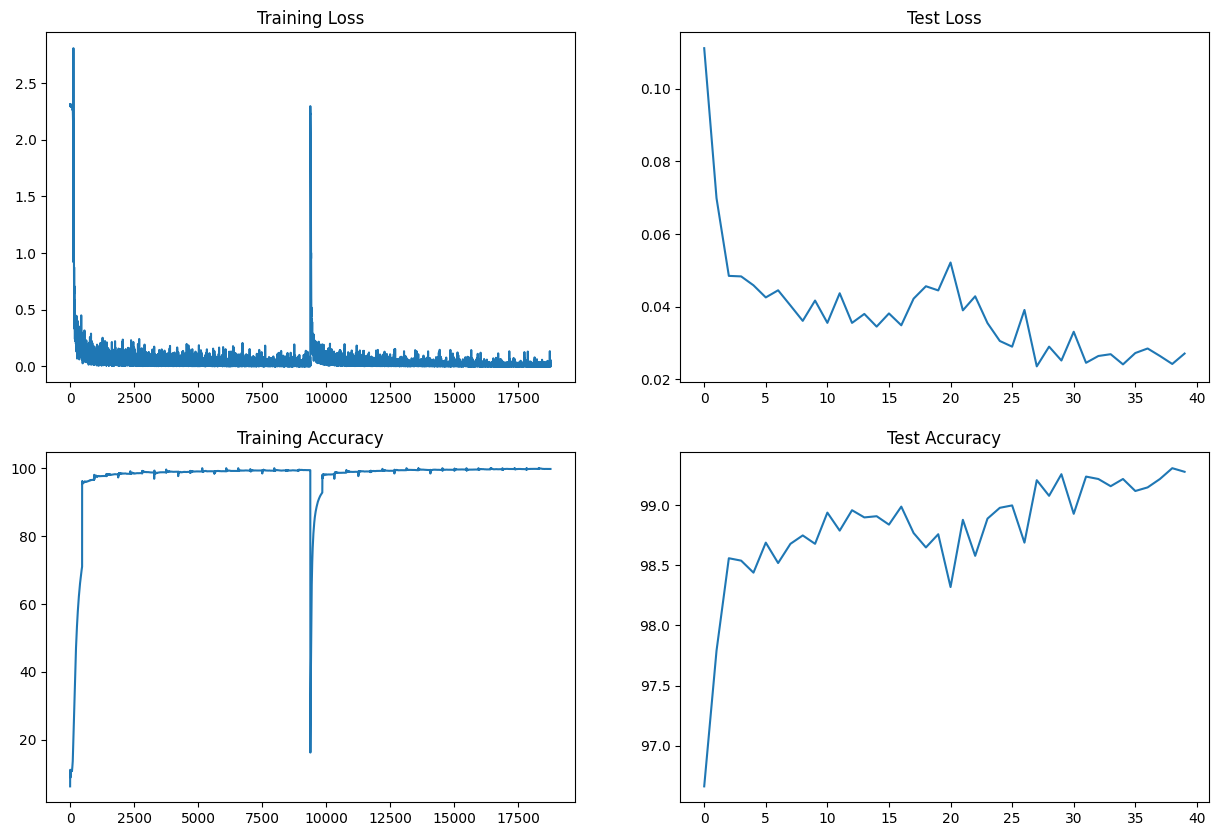

In [45]:
#train_losses

t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")